<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Linear regression

In this exercise, you will use linear regression to predict flat (apartment) prices. Training will be handled via gradient descent. We will:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a non-standard loss function.

Let's start by obtaining the data.

In [1]:
!wget --no-verbose -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget --no-verbose -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1
!head mieszkania.csv mieszkania_test.csv

2025-10-06 19:39:56 URL:https://ucb5735c9c0190b89a73c685a9d5.dl.dropboxusercontent.com/cd/0/inline/CytUW6NxaRwXQXp_y690cI7wQ-8_7gh5vb7hsdOyvwCkM-h1C91KB3fG1q3Hf-rVJnvMijsXZRF2hbxUXj-HH9j7JFOmsi8q3vaFDGuc4xSxqfSpkE79osIHqXfEbESmtWY/file?dl=1 [6211/6211] -> "mieszkania.csv" [1]
2025-10-06 19:39:57 URL:https://ucf8222bfbe66749a2fe2a82e59e.dl.dropboxusercontent.com/cd/0/inline/CyvDYNKu7aq3KH4N8W-jLPYe38IoJCZmkcQaKMPZN5lt5xwcPzqYSpa9FC1pMh1Mhv5DvTOaFVGEDCs--JZz0JkPywZhuLbk5JvyGsHoWI2XkcMFakWx3_5T3_fuk1v60FQ/file?dl=1 [6247/6247] -> "mieszkania_test.csv" [1]
==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_

Each row in the data represents a separate flat. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a flat's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,...`).

We should use only `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

In [2]:
%matplotlib inline

from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tqdm.auto import tqdm

NDArray = np.ndarray[Any, Any]

np.set_printoptions(precision=4, suppress=True)
np.random.seed(357)

## Loading and converting data

Let's start by loading the data and showing the range of prices we're working with.

In [3]:
def load(path: str) -> tuple[NDArray, NDArray]:
    """
    Returns (x, y) where:
    - x: input features, shape (n_apartments, n_features)
    - y: price, shape (n_apartments,)
    """
    data = pd.read_csv(path)
    y = data["cena"].to_numpy()
    x = data.loc[:, data.columns != "cena"].to_numpy()
    return x, y

In [4]:
x_train, y_train = load("mieszkania.csv")
x_test, y_test = load("mieszkania_test.csv")

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(200, 6) (200,)
(200, 6) (200,)


In [5]:
print(np.min(y_train), np.max(y_train), np.mean(y_train))

102572 1102309 507919.49


In [6]:
x_train[:3]

array([[104, 'mokotowo', 2, 2, 1940, 1],
       [43, 'ochotowo', 1, 1, 1970, 1],
       [128, 'grodziskowo', 3, 2, 1916, 1]], dtype=object)

We'll need to convert features to floats.

In [7]:
# Convert column 1 from str to (ordinal) int.
# (One-hot encoding would be better, but ordinal is OK for today.)
label_encoder = LabelEncoder()
label_encoder.fit(x_train[:, 1])
x_train[:, 1] = label_encoder.transform(x_train[:, 1])
x_test[:, 1] = label_encoder.transform(x_test[:, 1])

# Convert ints to float.
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

In [8]:
x_train[:3]

array([[ 104.,    1.,    2.,    2., 1940.,    1.],
       [  43.,    2.,    1.,    1., 1970.,    1.],
       [ 128.,    0.,    3.,    2., 1916.,    1.]])

## The loss and constant models

Our predictions should minimize the so-called *mean squared logarithmic error*:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's implement the loss function first.

In [9]:
def mse(ys: NDArray, ps: NDArray) -> np.float64:
    assert ys.shape == ps.shape
    return np.mean((ys - ps) * (ys - ps))

In [10]:
def msle(ys: NDArray, ps: NDArray) -> np.float64:
    assert ys.shape == ps.shape
    return np.mean((np.log(ys+1)-np.log(ps+1))**2)

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [11]:
mean_price = np.mean(y_train)

mse(y_train, np.full_like(y_train, mean_price))
msle(y_train, np.full_like(y_train, mean_price))

np.float64(0.3915250389336738)

Recall that outputing the mean minimizes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [12]:
cst = np.e**(np.mean([np.log(1+ys) for ys in y_train]))-1

msle(y_train, np.full_like(y_train, cst))

np.float64(0.36488961221465716)

## Linear regression (standard)

Now, let's implement training of a standard linear regression model via gradient descent.

In [13]:
def train(
    x: NDArray, y: NDArray, alpha: float = 1e-7, n_iterations: int = 100000
) -> tuple[NDArray, np.float64]:
    """Linear regression (which optimizes MSE). Returns (weights, bias)."""

    # B is batch size (number of observations).
    # F is number of (input) features.
    B, F = x.shape
    assert y.shape == (B,)

    w = np.zeros(F, dtype=float)
    b = 0.0

    for _ in range(n_iterations):

        y_pred = x @ w + b
        err = y_pred - y

        grad_w = (2/B)*(x.T @ err)
        grad_b = (2/B)*np.sum(err)

        w -= alpha*grad_w
        b -= alpha*grad_b

    return (w, b)

weights, bias = train(x_train, y_train)
preds_train = x_train@weights + bias
preds_test = x_test@weights + bias
print("train MSE:", mse(y_train, preds_train))
print("test MSE:", mse(y_test, preds_test))

train MSE: 14778719338.96594
test MSE: 18423067673.63713


## Linear regression (MSLE)

Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint:
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
Use the chain rule and previous computations to get formulas for the gradient.
</sup></sub></sup></sub></sup></sub>

In [14]:
def train_msle(
    x: NDArray, y: NDArray, alpha: float = 1e-7, n_iterations: int = 100000
) -> tuple[NDArray, np.float64]:
    """Linear regression (which optimizes MSE). Returns (weights, bias)."""

    # B is batch size (number of observations).
    # F is number of (input) features.
    B, F = x.shape
    assert y.shape == (B,)

    w = np.zeros(F, dtype=float)
    b = 0.0

    for _ in range(n_iterations):

        y_pred = x @ w + b

        y_pred_log = np.log(1+y_pred)
        y_log = np.log(1+y)

        err = y_pred_log - y_log

        grad_w = (2/B)*x.T @ (err/(1+y_pred))
        grad_b = (2/B)*np.sum(err/(1+y_pred))

        w -= alpha*grad_w
        b -= alpha*grad_b

    return (w, b)

weights, bias = train_msle(x_train, y_train)
preds_train = x_train@weights + bias
preds_test = x_test@weights + bias
print("train MSLE:", msle(y_train, preds_train))
print("test MSLE:", msle(y_test, preds_test))

train MSLE: 37.130688521448526
test MSLE: 38.14321485039422


## Feature engineering

Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code.

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Note that you may need to change the learning rate substantially.

Hint:
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

Hint 2:
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

In [15]:
from itertools import combinations

def feature_eng(x: NDArray) -> NDArray:
    new_x = x

    B, F = x.shape


    for i in range(2, F-2):
        combs = combinations(range(F), i)
        for comb in combs:
            new_column = np.ones((B, 1))
            for index in comb:
                new_column *= x[:, index][:, None]
            new_x = np.concatenate((new_x, new_column), axis=1)

    return new_x

new_x_train = feature_eng(x_train)
new_x_test = feature_eng(x_test)
print(new_x_train)

[[ 104.    1.    2. ...    4. 3880. 3880.]
 [  43.    2.    1. ...    1. 1970. 1970.]
 [ 128.    0.    3. ...    6. 5748. 3832.]
 ...
 [ 107.    0.    2. ...    0.    0.    0.]
 [ 117.    0.    3. ...    6. 5934. 3956.]
 [  56.    3.    2. ...    0.    0.    0.]]


In [16]:
weights, bias = train(new_x_train, y_train, alpha=1e-12)
preds_train = new_x_train@weights + bias
preds_test = new_x_test@weights + bias
print("train MSE:", mse(y_train, preds_train))
print("test MSE:", mse(y_test, preds_test))

weights, bias = train_msle(new_x_train, y_train)
preds_train = new_x_train@weights + bias
preds_test = new_x_test@weights + bias
print("train MSLE:", msle(y_train, preds_train))
print("test MSLE:", msle(y_test, preds_test))


train MSE: 13582282609.40337
test MSE: 17336339863.193775
train MSLE: 0.2548259000881113
test MSLE: 0.29205031373719725


# Validation

In this exercise you will implement a validation pipeline: split the non-test set into train and validation sets and select the best model based on validation results.

So far you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, you should be able to better anticipate the test time performance and compare different models and hyperparameters on datasets they are not over-fitted to.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise MSLE.

In [17]:
x_train_val, y_train_val = new_x_train, y_train
x_test, y_test = new_x_test, y_test


def random_split(
    x: NDArray, y: NDArray, val_ratio: float = 0.2
) -> tuple[tuple[NDArray, NDArray], tuple[NDArray, NDArray]]:
    """Returns (x_train, y_train), (x_val, y_val)."""

    idxs = np.random.permutation(len(x))

    val_idxs = idxs[:int(val_ratio*len(x))]
    train_idxs = idxs[len(val_idxs):]

    x_val, y_val = x[val_idxs], y[val_idxs]
    x_train, y_train = x[train_idxs], y[train_idxs]

    return (x_train, y_train), (x_val, y_val)



(x_train_2, y_train_2), (x_val, y_val) = random_split(x_train_val, y_train_val)

len(x_train), len(x_val), len(x_test)

(200, 40, 200)

In [18]:
(x_train_2, y_train_2), (x_val, y_val) = random_split(new_x_train, y_train)

weights, bias = train_msle(x_train_2, y_train_2)
preds_train = x_train_2@weights + bias
preds_val = x_val@weights + bias
preds_test = new_x_test@weights + bias
print("train MSLE:", msle(y_train_2, preds_train))
print("train VAL:", msle(y_val, preds_val))
print("test MSLE:", msle(y_test, preds_test))

train MSLE: 0.283563588084386
train VAL: 0.23959970341794593
test MSLE: 0.31533249514333456


## Cross-validation

To make the random split validation reliable, a significant chunk of training data may be needed. To get over this problem, one may apply cross-validation.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [19]:
####################################
# TODO: Implement cross-validation #
####################################
def kfold(x: NDArray, y: NDArray, n_folds: int = 5, shuffle: bool = False) -> list[float]:
    """Returns losses for each fold."""
    losses = []

    s = len(x)

    for i in range(n_folds):
      if shuffle:
        (x_train, y_train), (x_val, y_val) = random_split(x, y, val_ratio=1/n_folds)
      else:
        idxs_val = [j for j in range(i*(s//n_folds), (i+1)*(s//n_folds))]
        idxs_train = [j for j in range(s) if j < idxs_val[0] or j > idxs_val[-1]]

        x_train, y_train = x[idxs_train], y[idxs_train]
        x_val, y_val = x[idxs_val], y[idxs_val]

        weights, bias = train_msle(x_train, y_train)
        preds = x_val@weights + bias
        losses.append(msle(y_val, preds))

    return losses



losses = kfold(x_train_val, y_train_val, n_folds=3, shuffle=False)
print(f"k-fold loss: {np.mean(losses):.4f} +- {np.std(losses):.4f}")


k-fold loss: 0.2477 +- 0.0227


## Investigating input data

Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

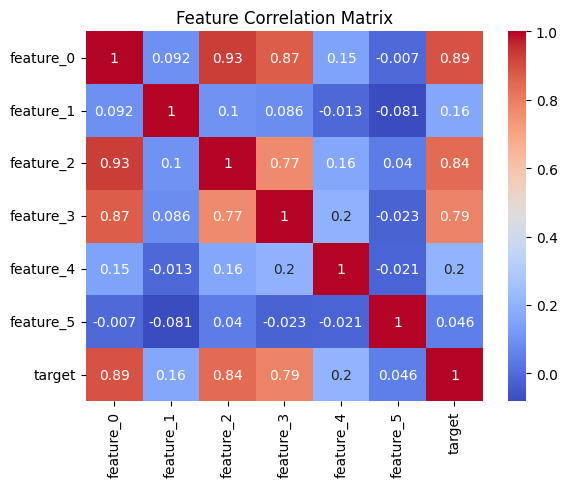

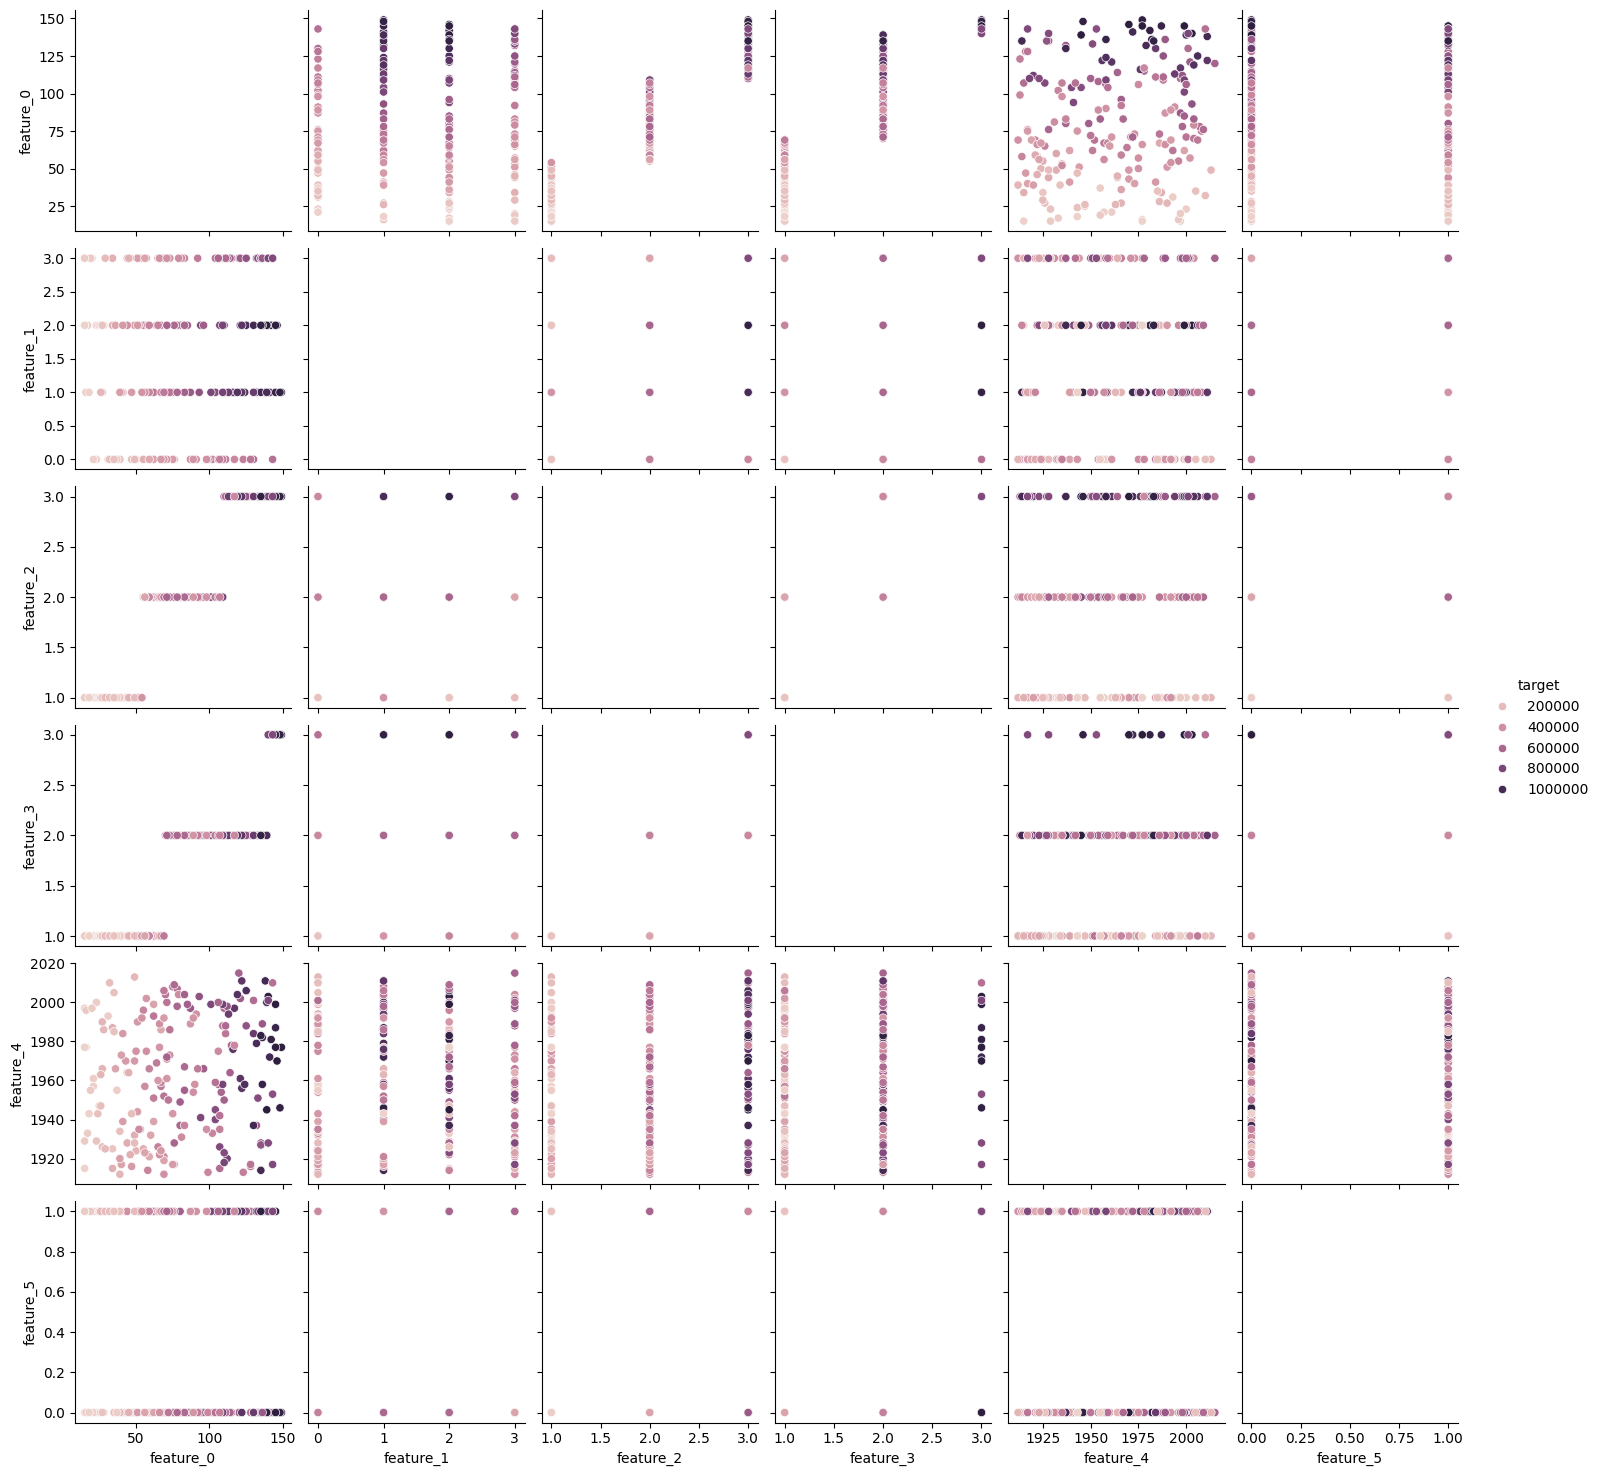

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(x_train, columns=[f'feature_{i}' for i in range(x_train.shape[1])])
df['target'] = y_train

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

sns.pairplot(df, hue='target')
plt.show()


We can see strong correlation between features:


*   3 and 0
*   2 and 0
*   2 and 3

As well as strong correlation between features 0, 2, 3 and the target.